In [1]:
# 데이터로드
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


import zipfile  # 압축파일 풀기
import os
import glob

#이미지 처리 관련
import cv2
import numpy as np
from PIL import Image
from tensorflow import keras # Import keras from tensorflow
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 파일 다운 wget 사용해서 url에서 파일 다운
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2024-12-09 08:24:54--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  15.3MB/s    in 18s     

2024-12-09 08:25:13 (14.5 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [3]:
with zipfile.ZipFile('/content/GTSRB_Final_Training_Images.zip', 'r') as target_file:

  target_file.extractall()

# 대략 43개 디렉토리.. 가지는 이미지가 학습데이터

In [4]:
#프로그램 호환성을 높이기 위해서root_dir 설정해둠
ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'GTSRB/Final_Training/Images/')

In [5]:
image_list = []
label_list = []

image_label_list = os.listdir(DATA_ROOT_DIR)   # 정답리스트

for label_name in image_label_list:  # 정답

  file_path = os.path.join(DATA_ROOT_DIR, label_name)
  img_file_list =  glob.glob(file_path+'/*.ppm')
# ppm 파일 읽어서 리스트에 저장
  for img_file in img_file_list:

    try:
      src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
      scr_img = cv2.resize(src_img, dsize=(32,32))            # 정답 디렉토리에 있는 OPEN CV 통해 읽기
      src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

      image_list.append(src_img)                #이미지와 정답 리스트에 추가
      label_list.append(float(label_name))    #정답에 해당하는 이미지를 순서대로 리스트에 추가

    except Exception as err:
      print(str(err), img_file)
      continue


In [6]:
# 이미지 크기 통일 (예: 32x32)
target_size = (32, 32)
image_list_resized = [np.array(Image.fromarray(img).resize(target_size)) for img in image_list]
x_train = np.array(image_list_resized).astype('float32')

In [7]:
# 레이블 값이 리스트 형태로 되어 있을 시, 스칼라로 변환해야한다
label_list = [label[0] if isinstance(label, (list, tuple)) else label for label in label_list]
y_train = np.array(label_list).astype('float32')

In [8]:
s = np.arange(len(x_train))

np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [9]:
SPLIT_RATIO = 0.

SPLIT_NUMS = int(SPLIT_RATIO*len(x_train))

x_test = x_train[0:SPLIT_NUMS:]
y_test = y_train[0:SPLIT_NUMS:]

x_test = x_train[SPLIT_NUMS:]
y_test = y_train[SPLIT_NUMS:]

In [10]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [11]:
print('x_train.shape =', x_train.shape, ',y_train.shape = ', y_train.shape)
print('x_test.shape =', x_test.shape, ',y_test.shape = ', y_test.shape)

x_train.shape = (39209, 32, 32, 3) ,y_train.shape =  (39209,)
x_test.shape = (39209, 32, 32, 3) ,y_test.shape =  (39209,)


In [12]:
n_classes = len(os.listdir(DATA_ROOT_DIR))

model = Sequential()

model.add(Conv2D(input_shape=(32, 32, 3),kernel_size=(3,3), filters=32, activation='relu'))
model.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,241,963 (12.37 MB)

 Trainable params: 3,241,963 (12.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.Adam(), metrics=['accuracy'])

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(x_train, y_train, batch_size=32, epochs=30,
                 validation_data=(x_test, y_test), callbacks=[earlystopping])

Epoch 1/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5595 - loss: 1.6379 - val_accuracy: 0.9750 - val_loss: 0.1189
Epoch 2/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9330 - loss: 0.2298 - val_accuracy: 0.9924 - val_loss: 0.0427
Epoch 3/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9590 - loss: 0.1359 - val_accuracy: 0.9954 - val_loss: 0.0203
Epoch 4/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9727 - loss: 0.0929 - val_accuracy: 0.9980 - val_loss: 0.0100
Epoch 5/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9779 - loss: 0.0709 - val_accuracy: 0.9986 - val_loss: 0.0057
Epoch 6/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9834 - loss: 0.0574 - val_accuracy: 0.9993 - val_loss: 0.0046
Epoch 7/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9851 - loss: 0.0511 - val_accuracy: 0.9990 - val_loss: 0.0043
Epoch 8/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9863 - loss: 0.0

In [22]:
!pip install matplot

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.3/748.3 kB 29.9 MB/s eta 0:00:00
  Created wheel for SimpleWebSocketServer: filename=SimpleWebSocketServer-0.1.2-py3-none-any.whl size=9667 sha256=1a787aa3d11a146e21a4e6e8714cd853a282c980b0f7979a106a220ae795029f
  Stored in directory: /root/.cache/pip/wheels/af/cb/9d/23ef01c9c26b978be6d29ed456d7348abd0e96b1563049bd63
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26303 sha256=e804c56892b5d0c1bdc6a46799e1133bb74ae03264fb5bc0fa682247d0de232e
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
  Created wheel for ushlex: filename=ushlex-0.99.1-py3-none-any.whl size=4394 sha256=0e3e40bb

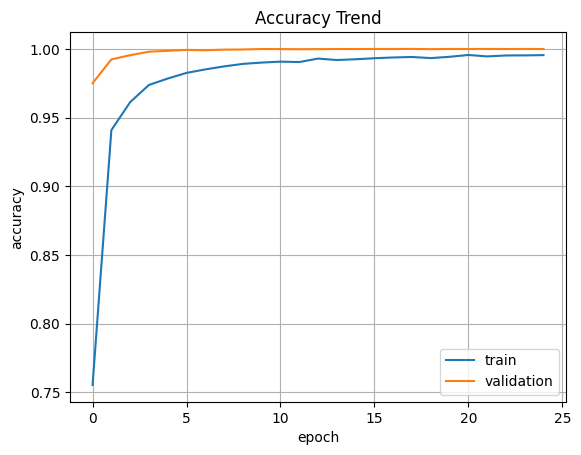

In [24]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

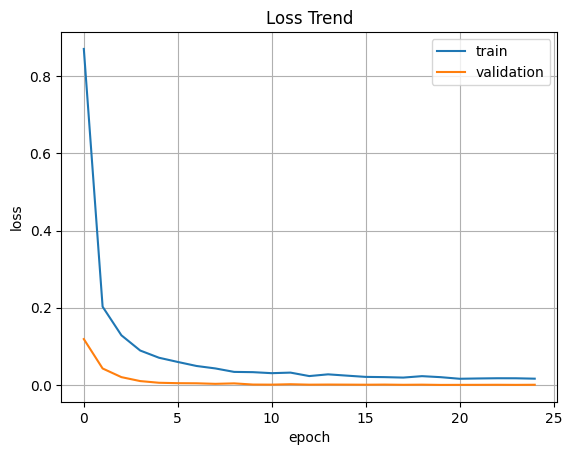

In [25]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()